# import statements

In [1]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator
import matplotlib.pyplot as plt
import datetime
import scipy.fftpack
from glob import glob
import librosa

# And the tf and keras framework, thanks to Google
import tensorflow as tf
from tensorflow import keras

In [2]:
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [3]:
def distance(point1, point2, n):
    """
    Calculate the Euclidean distance between two points.
    point1: list of floats
    point2: list of floats
    n: int, number of dimensions
    """
    distance = 0
    for x in range(n):
        distance += pow((point1[x] - point2[x]), 2)
    return math.sqrt(distance)

In [4]:
def k_nearest(trainset, instance, k):
    """
    Calculates the distance between the specified instance and the k nearest neighbors in the training set.
    trainset: a list of training instances
    instance: the instance to classify
    k: the number of neighbors to consider
    """
    distances = []
    for i in range(len(trainset)):
        dist = np.linalg.norm(np.array(instance) - np.array(trainset[i]))
    distances.sort()
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors


# Loading in features and saving them as a csv file

In [5]:
# Load in the data from the train folder
train_files = glob('train/*')

# Load the audio file using librosa
# y = audio time series
# sr = sampling rate of y
time_series = []
sampling_rates = []
#load the first 10 files
for i in range(0, 799):
    y, sr = librosa.load(train_files[i])
    time_series.append(y)
    sampling_rates.append(sr)


# convert the time series and sampling rates to a pandas dataframe
df = pd.DataFrame({'time_series': time_series})
# save the dataframe to a csv file
df.to_csv('time_series.csv', index=False)

In [6]:
print(type(time_series))
print(type(time_series[0]))

<class 'list'>
<class 'numpy.ndarray'>


# Basic feature extraction

In [7]:
def extract_features(series):
    """
    Uses Librosa to extract features from the time series.
    series: list of floats
    returns:
    spectral_centroid: the center of mass of the spectrum
    spectral rolloff: the frequency below which 85% of the magnitude distribution is concentrated
    spectral bandwidth: the width of the band of frequencies
    spectral contrast: the difference in amplitude between peaks and valleys in the spectrum
    spectral flatness: the flatness of a signal
    spectral rms: the root mean square of the signal
    """
    spectral_centroid = librosa.feature.spectral_centroid(y=series)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=series)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=series)
    spectral_contrast = librosa.feature.spectral_contrast(y=series)
    spectral_flatness = librosa.feature.spectral_flatness(y=series)
    spectral_rms = librosa.feature.rms(y=series)
    return spectral_centroid, spectral_rolloff, spectral_bandwidth, spectral_contrast, spectral_flatness, spectral_rms

centroids = []
rolloffs = []
bandwidths = []
contrasts = []
flatnesses = []
rms = []

for i in range(0, 799):
    spectral_centroid, spectral_rolloff, spectral_bandwidth, spectral_contrast, spectral_flatness, spectral_rms = extract_features(time_series[i])
    centroids.append(spectral_centroid)
    rolloffs.append(spectral_rolloff)
    bandwidths.append(spectral_bandwidth)
    contrasts.append(spectral_contrast)
    flatnesses.append(spectral_flatness)
    rms.append(spectral_rms)

# convert the features to a pandas dataframe

    



# Plot features of one of the columns in the dataset

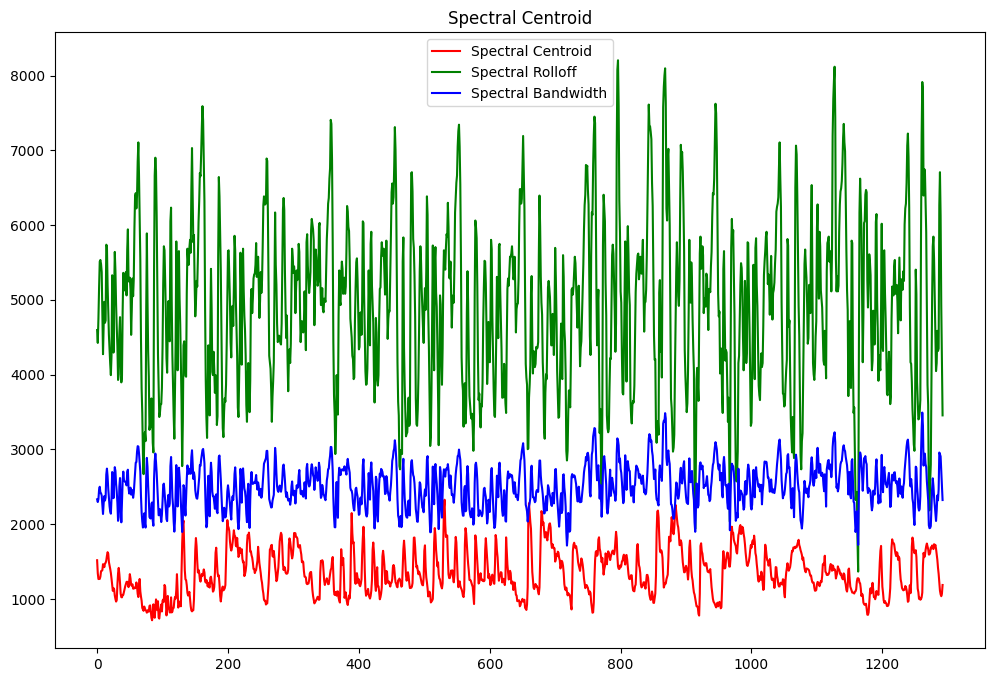

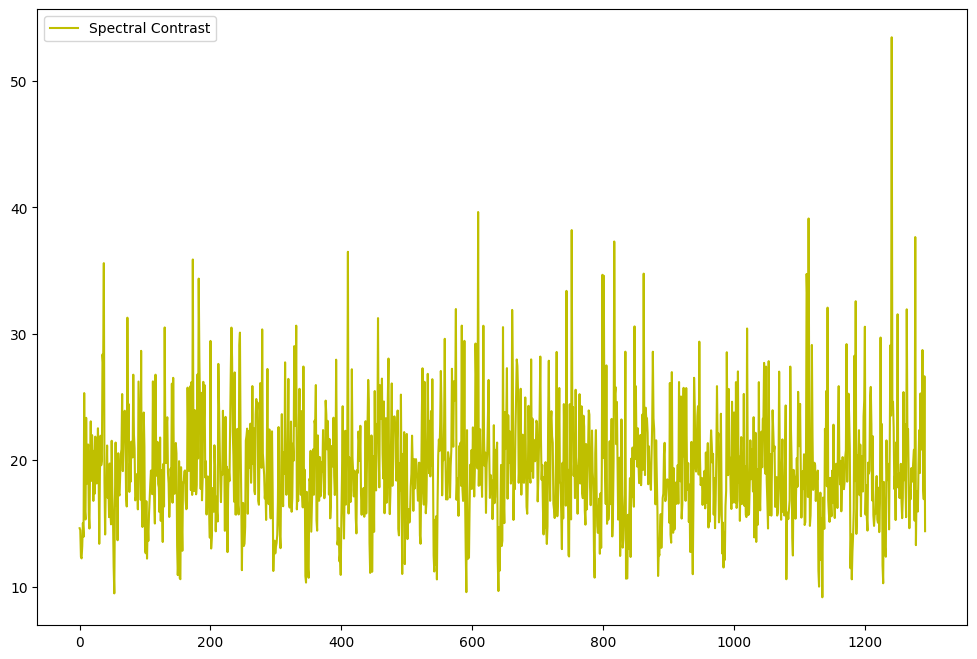

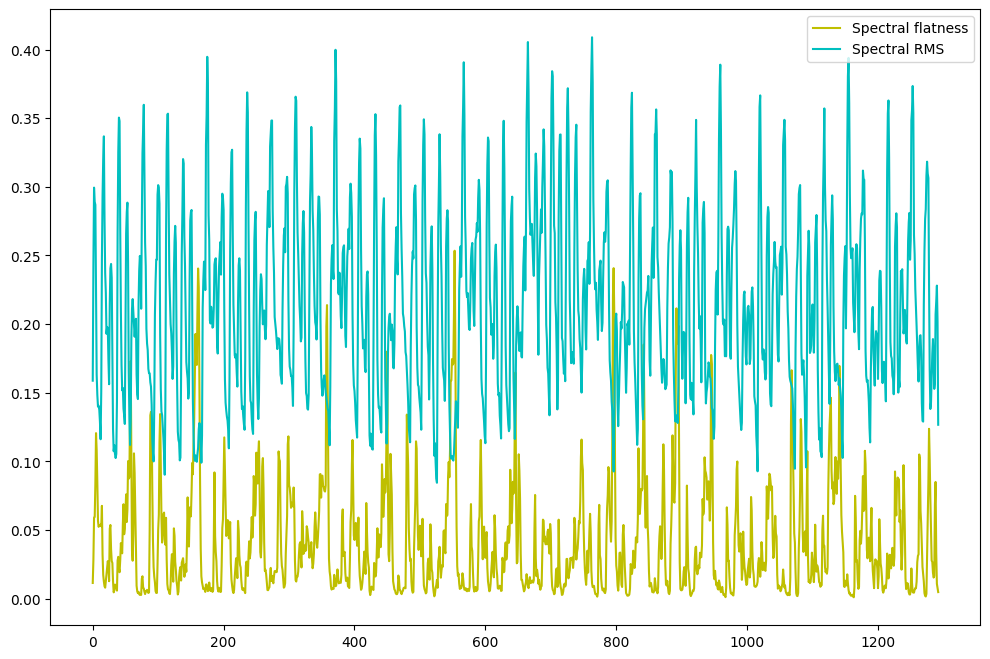

In [ ]:
# plot the spectral centroid
plt.figure(figsize=(12, 8))
plt.plot(centroids[1][0], color='r')
plt.plot(rolloffs[0][0], color='g')
plt.plot(bandwidths[0][0], color='b')
plt.legend(('Spectral Centroid', 'Spectral Rolloff', 'Spectral Bandwidth'))
plt.title('Spectral Centroid')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(contrasts[0][0], color='y')
plt.legend(('Spectral Contrast', 'Spectral Flatness', 'Spectral RMS'))

plt.figure(figsize=(12, 8))
plt.plot(flatnesses[0][0], color='y')
plt.plot(rms[0][0], color='c')
plt.legend(('Spectral flatness', 'Spectral RMS'))




# Store and display the spectral centroids

# Plot all the features from features.csv

NameError: name 'fft_features' is not defined

# Rhythm extraction

In [ ]:
def get_rhythm_features(signal_array, sr):
    """
    Extracts rhythm features from the signal.
    signal: pandas series, the audio signal
    sr: int, the sampling rate of the signal
    returns:
    tempo: float, the tempo of the signal
    beats: numpy array, the beats of the signal
    """
    tempo, beats = librosa.beat.beat_track(y = signal_array, sr = sr)
    return tempo, beats

tempos = []
beats = []

for i in range(0, 799):
    tempo, beat = get_rhythm_features(time_series[i], sampling_rates[i])
    tempos.append(tempo)
    beats.append(beat)

# Graph the rhythm features

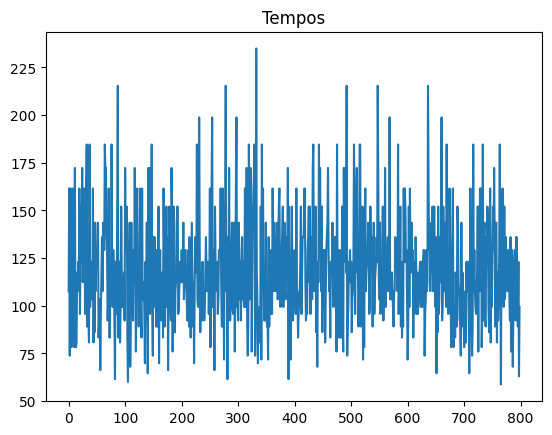

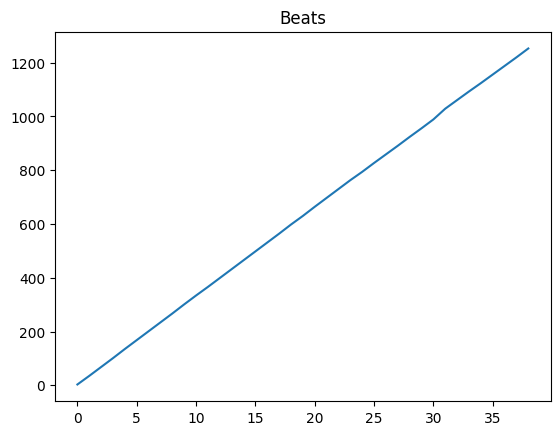

<class 'list'>


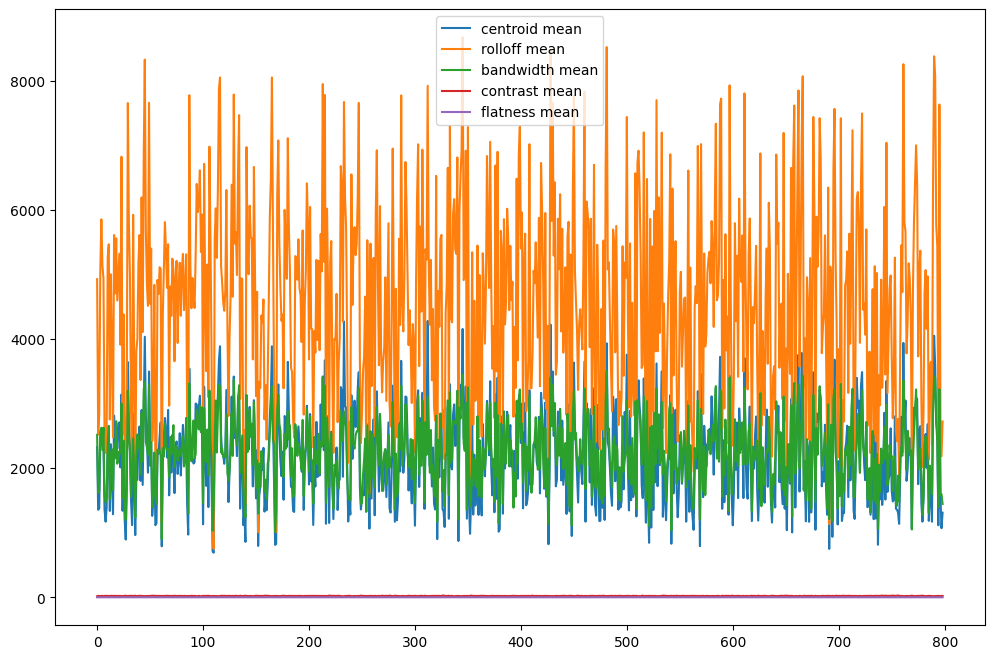

In [37]:


centroid_means = []
df = pd.DataFrame({'centroid_means': centroid_means})
df.to_csv('features/centroid_means.csv', index=False)
rolloff_means = []
bandwidth_means = []
contrast_means = []
flatness_means = []
rms_means = []

centroid_stds = []
rolloff_stds = []
bandwidth_stds = []
contrast_stds = []
flatness_stds = []
rms_stds = []

centroid_maxs = []
rolloff_maxs = []
bandwidth_maxs = []
contrast_maxs = []
flatness_maxs = []
rms_maxs = []

centroid_mins = []
rolloff_mins = []
bandwidth_mins = []
contrast_mins = []
flatness_mins = []
rms_mins = []



for i in range(0, 799):
    centroid_means.append(np.mean(centroids[i]))
    rolloff_means.append(np.mean(rolloffs[i]))
    bandwidth_means.append(np.mean(bandwidths[i]))
    contrast_means.append(np.mean(contrasts[i]))
    flatness_means.append(np.mean(flatnesses[i]))
    rms_means.append(np.mean(rms[i]))
    centroid_stds.append(np.std(centroids[i]))
    rolloff_stds.append(np.std(rolloffs[i]))
    bandwidth_stds.append(np.std(bandwidths[i]))
    contrast_stds.append(np.std(contrasts[i]))
    flatness_stds.append(np.std(flatnesses[i]))
    rms_stds.append(np.std(rms[i]))
    centroid_maxs.append(np.max(centroids[i]))
    rolloff_maxs.append(np.max(rolloffs[i]))
    bandwidth_maxs.append(np.max(bandwidths[i]))    
    contrast_maxs.append(np.max(contrasts[i]))
    flatness_maxs.append(np.max(flatnesses[i]))
    rms_maxs.append(np.max(rms[i]))
    centroid_mins.append(np.min(centroids[i]))
    rolloff_mins.append(np.min(rolloffs[i]))
    bandwidth_mins.append(np.min(bandwidths[i]))
    contrast_mins.append(np.min(contrasts[i]))
    flatness_mins.append(np.min(flatnesses[i]))
    rms_mins.append(np.min(rms[i]))

features = [centroid_means, rolloff_means, bandwidth_means, contrast_means, flatness_means, rms_means, centroid_stds, rolloff_stds, bandwidth_stds, contrast_stds, flatness_stds, rms_stds, centroid_maxs, rolloff_maxs, bandwidth_maxs, contrast_maxs, flatness_maxs, rms_maxs, centroid_mins, rolloff_mins, bandwidth_mins, contrast_mins, flatness_mins, rms_mins, tempos]
print(type(features[24]))
df = pd.DataFrame({'features': features})
df = df.transpose()



# Save the features to a csv file
df = pd.DataFrame({'centroid_means': centroid_means})
df.to_csv('features/centroid_means.csv', index=False)
df = pd.DataFrame({'rolloff_means': rolloff_means})
df.to_csv('features/rolloff_means.csv', index=False)
df = pd.DataFrame({'bandwidth_means': bandwidth_means})
df.to_csv('features/bandwidth_means.csv', index=False)
df = pd.DataFrame({'contrast_means': contrast_means})
df.to_csv('features/contrast_means.csv', index=False)
df = pd.DataFrame({'flatness_means': flatness_means})
df.to_csv('features/flatness_means.csv', index=False)
df = pd.DataFrame({'rms_means': rms_means})
df.to_csv('features/rms_means.csv', index=False)
df = pd.DataFrame({'centroid_stds': centroid_stds})
df.to_csv('features/centroid_stds.csv', index=False)
df = pd.DataFrame({'rolloff_stds': rolloff_stds})
df.to_csv('features/rolloff_stds.csv', index=False)
df = pd.DataFrame({'bandwidth_stds': bandwidth_stds})
df.to_csv('features/bandwidth_stds.csv', index=False)
df = pd.DataFrame({'contrast_stds': contrast_stds})
df.to_csv('features/contrast_stds.csv', index=False)
df = pd.DataFrame({'flatness_stds': flatness_stds})
df.to_csv('features/flatness_stds.csv', index=False)
df = pd.DataFrame({'rms_stds': rms_stds})
df.to_csv('features/rms_stds.csv', index=False)
df = pd.DataFrame({'centroid_maxs': centroid_maxs})
df.to_csv('features/centroid_maxs.csv', index=False)
df = pd.DataFrame({'rolloff_maxs': rolloff_maxs})
df.to_csv('features/rolloff_maxs.csv', index=False)
df = pd.DataFrame({'bandwidth_maxs': bandwidth_maxs})
df.to_csv('features/bandwidth_maxs.csv', index=False)
df = pd.DataFrame({'contrast_maxs': contrast_maxs})
df.to_csv('features/contrast_maxs.csv', index=False)
df = pd.DataFrame({'flatness_maxs': flatness_maxs})
df.to_csv('features/flatness_maxs.csv', index=False)
df = pd.DataFrame({'rms_maxs': rms_maxs})
df.to_csv('features/rms_maxs.csv', index=False)
df = pd.DataFrame({'centroid_mins': centroid_mins})
df.to_csv('features/centroid_mins.csv', index=False)
df = pd.DataFrame({'rolloff_mins': rolloff_mins})
df.to_csv('features/rolloff_mins.csv', index=False)
df = pd.DataFrame({'bandwidth_mins': bandwidth_mins})
df.to_csv('features/bandwidth_mins.csv', index=False)
df = pd.DataFrame({'contrast_mins': contrast_mins})
df.to_csv('features/contrast_mins.csv', index=False)
df = pd.DataFrame({'flatness_mins': flatness_mins})
df.to_csv('features/flatness_mins.csv', index=False)
df = pd.DataFrame({'rms_mins': rms_mins})
df.to_csv('features/rms_mins.csv', index=False)
df = pd.DataFrame({'tempos': tempos})
df.to_csv('features/tempos.csv', index=False)






(799, 25)


C:\Users\tapic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


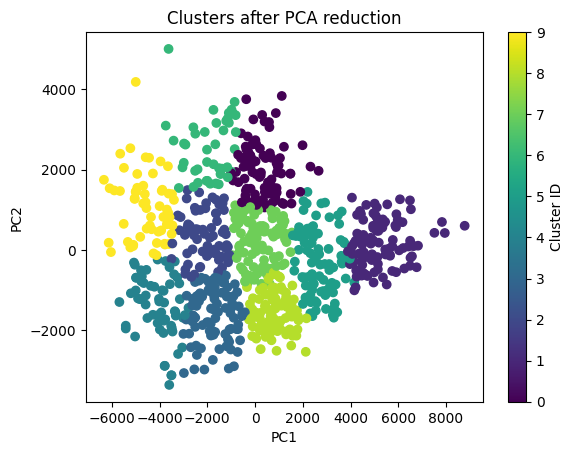

In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

# Convert list of features to numpy array
features = np.array(features)
features = features.transpose()
print(features.shape)
# Create a KMeans instance
kmeans = KMeans(n_clusters=10)  # choose the appropriate number of clusters

# Fit the model to the data
kmeans.fit(features)

# Get the cluster assignments for each instance
cluster_assignments = kmeans.labels_

# Reduce the data to two dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Create a scatter plot of the reduced data
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_assignments, cmap='viridis')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters after PCA reduction')
plt.colorbar(label='Cluster ID')

plt.show()